In [1]:
import at
import at.plot
from importlib.resources import files, as_file

In [2]:
from at.future import VariableBase, VariableList, CustomVariable, match
from at import LocalOpticsObservable, ObservableList

# Correlated variables

In this example of correlation between variables, we vary the length of the two drifts
surrounding a monitor but keep the sum of their lengths constant.

Using these 2 correlated variables, we will match a constraint on the monitor.

## Load a test lattice

In [3]:
fname = 'hmba.mat'
with as_file(files('machine_data') / fname) as path:
    hmba_lattice = at.load_lattice(path)

Isolate the two drifts

In [4]:
dr1 = hmba_lattice["DR_01"][0]
dr2 = hmba_lattice["DR_02"][0]

Get the total length to be preserved

In [5]:
l1 = dr1.Length
l2 = dr2.Length
ltot = l1 + l2

Create a constraint {math}`\beta_y=3.0` on `BPM_01`

In [6]:
obs1 = LocalOpticsObservable('BPM_01', 'beta', plane='v', target=3.0)

## Method 1: using a {py:class}`~.variables.CustomVariable`

For this, we need to define the get and set function:

In [7]:
def _setfun(value, dr1, dr2, total_length, **_):
    dr1.Length = value
    dr2.Length = total_length - value

def _getfun(dr1, dr2, total_length, **_):
    return  dr1.Length

Then we can create the :py:class:`.CustomVariable` object:

In [8]:
var0 = CustomVariable(_setfun, _getfun, dr1, dr2, ltot, bounds=(0.0, ltot))

### Run the matching

In [9]:
variables = VariableList([var0])
constraints = ObservableList([obs1], ring=hmba_lattice)
match(hmba_lattice, variables, constraints, verbose=1)


1 constraints, 1 variables, using method trf

`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.6515e+00, final cost 9.6605e-27, first-order optimality 9.88e-14.

Constraints:

    location              Initial            Actual         Low bound        High bound         deviation 
beta[y]
    BPM_01                5.30283               3.0               3.0               3.0        1.0924e-08 

Variables:

        Name      Initial          Final        Variation

        var1    2.651400e+00    9.693778e-01   -1.682022e+00


### Show the modified lattice

In [10]:
for elem in hmba_lattice.select([2,3,4]):
    print(elem)

Drift:
       FamName: DR_01
        Length: 0.969377825260562
    PassMethod: DriftPass
Monitor:
       FamName: BPM_01
        Length: 0.0
    PassMethod: IdentityPass
        Offset: [0 0]
       Reading: [0 0]
      Rotation: [0 0]
         Scale: [1 1]
Drift:
       FamName: DR_02
        Length: 1.7245741747394379
    PassMethod: DriftPass


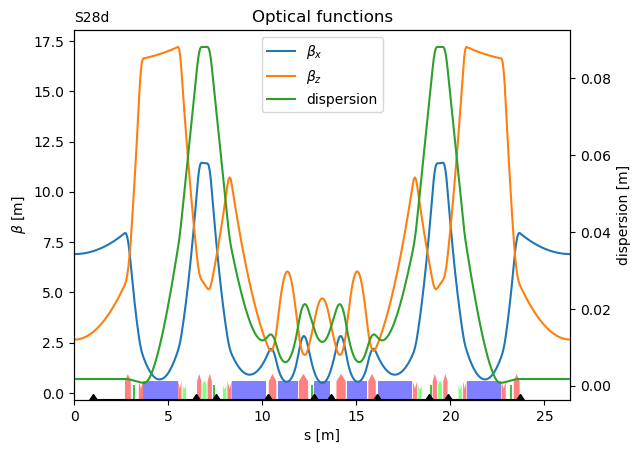

(<Axes: title={'left': 'S28d', 'center': 'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <Axes: ylabel='dispersion [m]'>,
 <Axes: >)

In [11]:
hmba_lattice.plot_beta()

The first BPM is moved to a location where {math}`\beta_y=3.0`

Restore the lattice

In [12]:
dr1.Length = l1
dr2.Length = l2

## Method 2: derivating the {py:class}`~.variables.VariableBase` class

We define a new variable class which will act on the two elements and fulfil the constraint

### Define a variable coupling two drift lengths so that their sum is constant:

In [13]:
class ElementShifter(VariableBase):
    def __init__(self, dr1, dr2, total_length=None, **kwargs):
        """Varies the length of the elements *dr1* and *dr2*
        keeping the sum of their lengths equal to *total_length*.

        If *total_length* is None, it is set to the initial total length
        """        
        if total_length is None:
            total_length = dr1.Length + dr2.Length
        super().__init__(dr1, dr2, total_length, bounds=(0.0, total_length), **kwargs)

    def _setfun(self, value, dr1, dr2, total_length, **_):
        dr1.Length = value
        dr2.Length = total_length - value

    def _getfun(self, dr1, *args, **kwargs):
        return dr1.Length

This method is more powerful, for instance by allowing processing in the __init__
method.

Create a variable moving the monitor `BPM_01`

In [14]:
var0 = ElementShifter(dr1, dr2, name='DR_01', total_length=ltot)

### Run the matching

In [15]:
variables = VariableList([var0])
constraints = ObservableList([obs1], ring=hmba_lattice)
match(hmba_lattice, variables, constraints, verbose=1)


1 constraints, 1 variables, using method trf

`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.6515e+00, final cost 9.6605e-27, first-order optimality 9.88e-14.

Constraints:

    location              Initial            Actual         Low bound        High bound         deviation 
beta[y]
    BPM_01                5.30283               3.0               3.0               3.0        1.0924e-08 

Variables:

        Name      Initial          Final        Variation

       DR_01    2.651400e+00    9.693778e-01   -1.682022e+00


### Show the modified lattice

In [16]:
for elem in hmba_lattice.select([2,3,4]):
    print(elem)

Drift:
       FamName: DR_01
        Length: 0.969377825260562
    PassMethod: DriftPass
Monitor:
       FamName: BPM_01
        Length: 0.0
    PassMethod: IdentityPass
        Offset: [0 0]
       Reading: [0 0]
      Rotation: [0 0]
         Scale: [1 1]
Drift:
       FamName: DR_02
        Length: 1.7245741747394379
    PassMethod: DriftPass


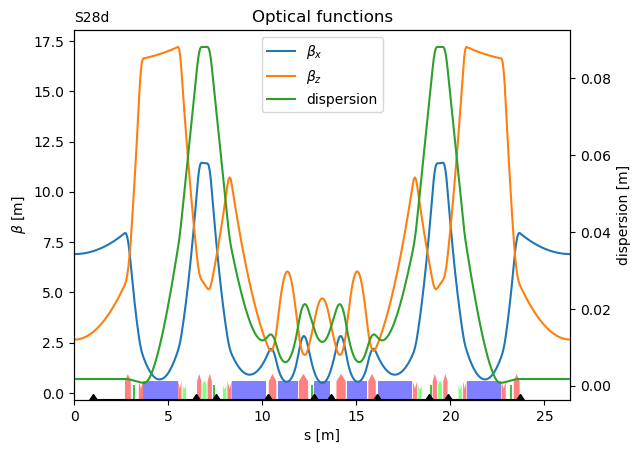

(<Axes: title={'left': 'S28d', 'center': 'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <Axes: ylabel='dispersion [m]'>,
 <Axes: >)

In [17]:
hmba_lattice.plot_beta()